# Elevation Map Rough Draft

This is a rough draft of the elevation map.  Just proving the concepts really making sure everything is on the correct path

In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import geoplot as gplt
import geopandas as gpd
import pylas
import gc
from shapely.geometry import Point
import pandas as pd
import utm
import zipfile
from matplotlib.colors import LogNorm, TwoSlopeNorm, Normalize

epsg = 4289
lasPath = './USGS_LPC_LA_UpperDeltaPlain_2017_LAS_2018/las/tiled/'
extent = (-90.14003111,  29.86560481, -89.87, 30.08)

In [2]:
neighborhoodDf = gpd.read_file('zip://./NewOrleansShapeFiles/Neighborhood_Statistical_Areas.zip!Neighborhood_Statistical_Areas.shp').to_crs(epsg=epsg)
neighborhoodDf['Name'] = neighborhoodDf['GNOCDC_LAB'].map(lambda x: x.title().replace(' ',"\n").split('-')[0])
neighborhoodDf['centers'] = neighborhoodDf['geometry'].apply(lambda x: x.representative_point())
waterDf = gpd.read_file('zip://./NewOrleansShapeFiles/water.zip!WATER2.SHP')
neighborhoodDf.head()

,OBJECTID,GNOCDC_LAB,Shape_Leng,Shape_Area,geometry,Name,centers
0,1009,U.S. NAVAL BASE,24814.676237,2.965424e+07,"POLYGON ((-90.02667 29.95320, -90.02546 29.952...",U.S.\nNaval\nBase,POINT (-90.02635 29.94656)
1,1010,ALGIERS POINT,15434.791720,1.375080e+07,"POLYGON ((-90.04537 29.95810, -90.04558 29.955...",Algiers\nPoint,POINT (-90.05225 29.95256)
2,1011,WHITNEY,25858.258690,1.842169e+07,"POLYGON ((-90.03807 29.95670, -90.03838 29.953...",Whitney,POINT (-90.04214 29.94469)
3,1012,AUDUBON,39015.654380,6.325782e+07,"POLYGON ((-90.10963 29.94135, -90.10984 29.940...",Audubon,POINT (-90.12234 29.93265)
4,1013,OLD AURORA,39878.264239,8.663475e+07,"POLYGON ((-90.01203 29.94594, -90.01206 29.945...",Old\nAurora,POINT (-89.99973 29.92678)


In [3]:
lasDf = gpd.GeoDataFrame(pd.read_pickle('./processedData.pickle'))
groundMask = lasDf['pointType']==2
lasDf['elevationFeet'] = 3.28084 * lasDf['elevation']
norm = Normalize(vmin=-10, vmax=10, clip=True)
lasDf['elevationNorm'] = norm(lasDf['elevationFeet'], clip=True)

In [4]:
extent = (-90.14003111,  29.86560481, -89.87, 30.08)

def graphMap(saveFig = False, showLidar = True, extent=extent, annotate=False, webMerc= False):
    projection = gplt.LambertCylindrical() if not webMerc else gplt.WebMercator()
    fig, ax = plt.subplots(figsize=(26,18), subplot_kw={'projection': projection})

    gplt.polyplot(neighborhoodDf, edgecolor='black', facecolor='#ffffff', projection=projection, ax=ax, extent=extent, zorder=19)
    if showLidar:
        gplt.choropleth(lasDf[groundMask],hue='elevationNorm', legend=True, ax=ax, projection=projection, zorder=20, extent=extent, cmap='gnuplot')
        
    gplt.polyplot(waterDf,ax=ax, projection=projection, edgecolor='#abd3df', facecolor='#abd3df', extent=extent, zorder=22)
    gplt.polyplot(neighborhoodDf, edgecolor='black', facecolor=(1,0,0,0), projection=projection, ax=ax, extent=extent, zorder=23)
    
    #currently this doesnt work
    if annotate:
        for idx,neighborhood in neighborhoodDf.iterrows():
            ax.annotate(text=neighborhood['Name'], xy=(neighborhood['centers'].x,neighborhood['centers'].y), \
               va='center',ha='center', zorder=100)

    cbar = fig.get_axes()[-1]
    labels = [str(int(x)) + ' feet' for x in norm.inverse(cbar.get_yticks())]
    labels[0] = '<= -10 feet'
    labels[-1] = '>= 10 feet'
    cbar.set_yticklabels(labels)

    ax.set_facecolor('#ffffce')
    ax.set_title('Feet Above See Level')
    fig.tight_layout()
    
    if webMerc:
        gplt.webmap(neighborhoodDf, projection=projection,ax=ax, extent=extent)

    if saveFig:
        fig.savefig(saveFig)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator


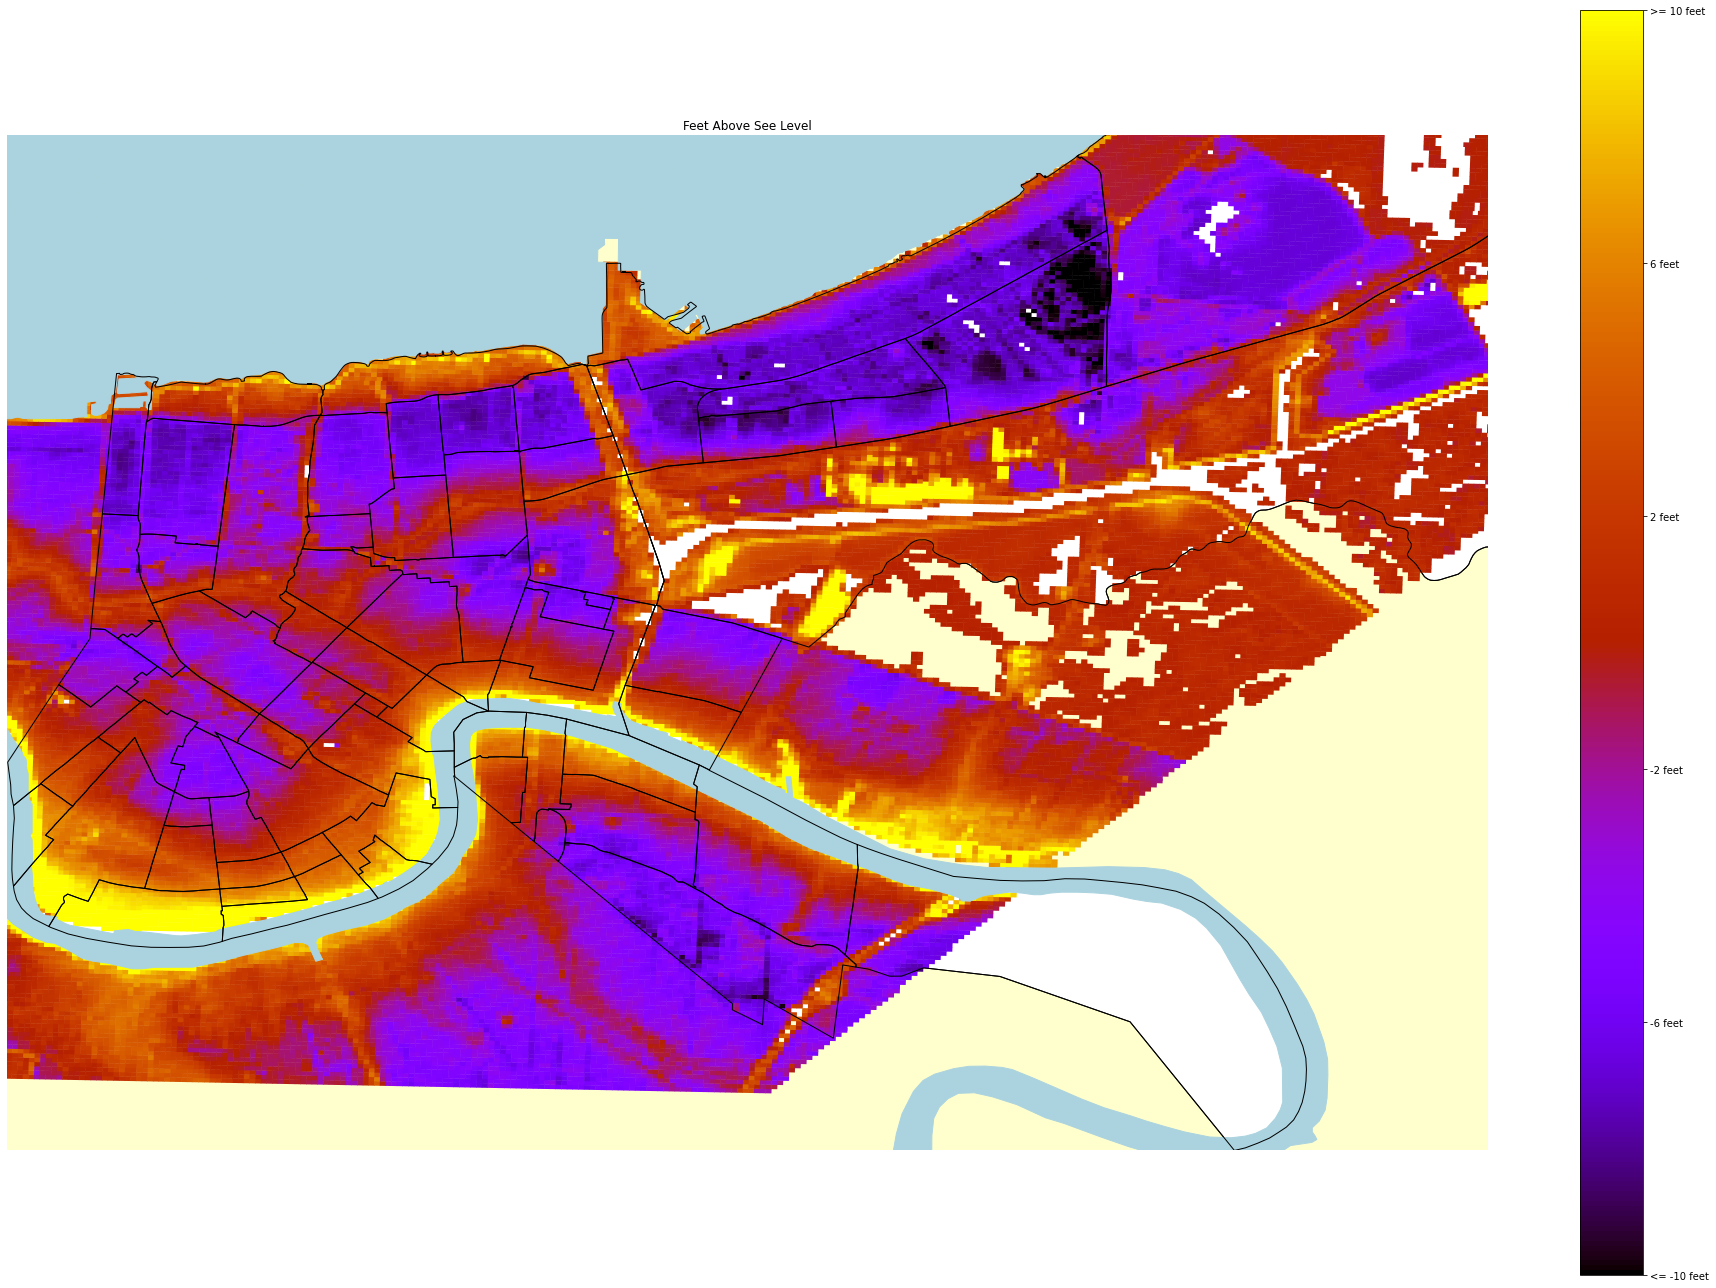

In [5]:
graphMap(saveFig='NewOrleansElevation1.png',\
         showLidar=True,\
         annotate=False,\
         webMerc=False)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator


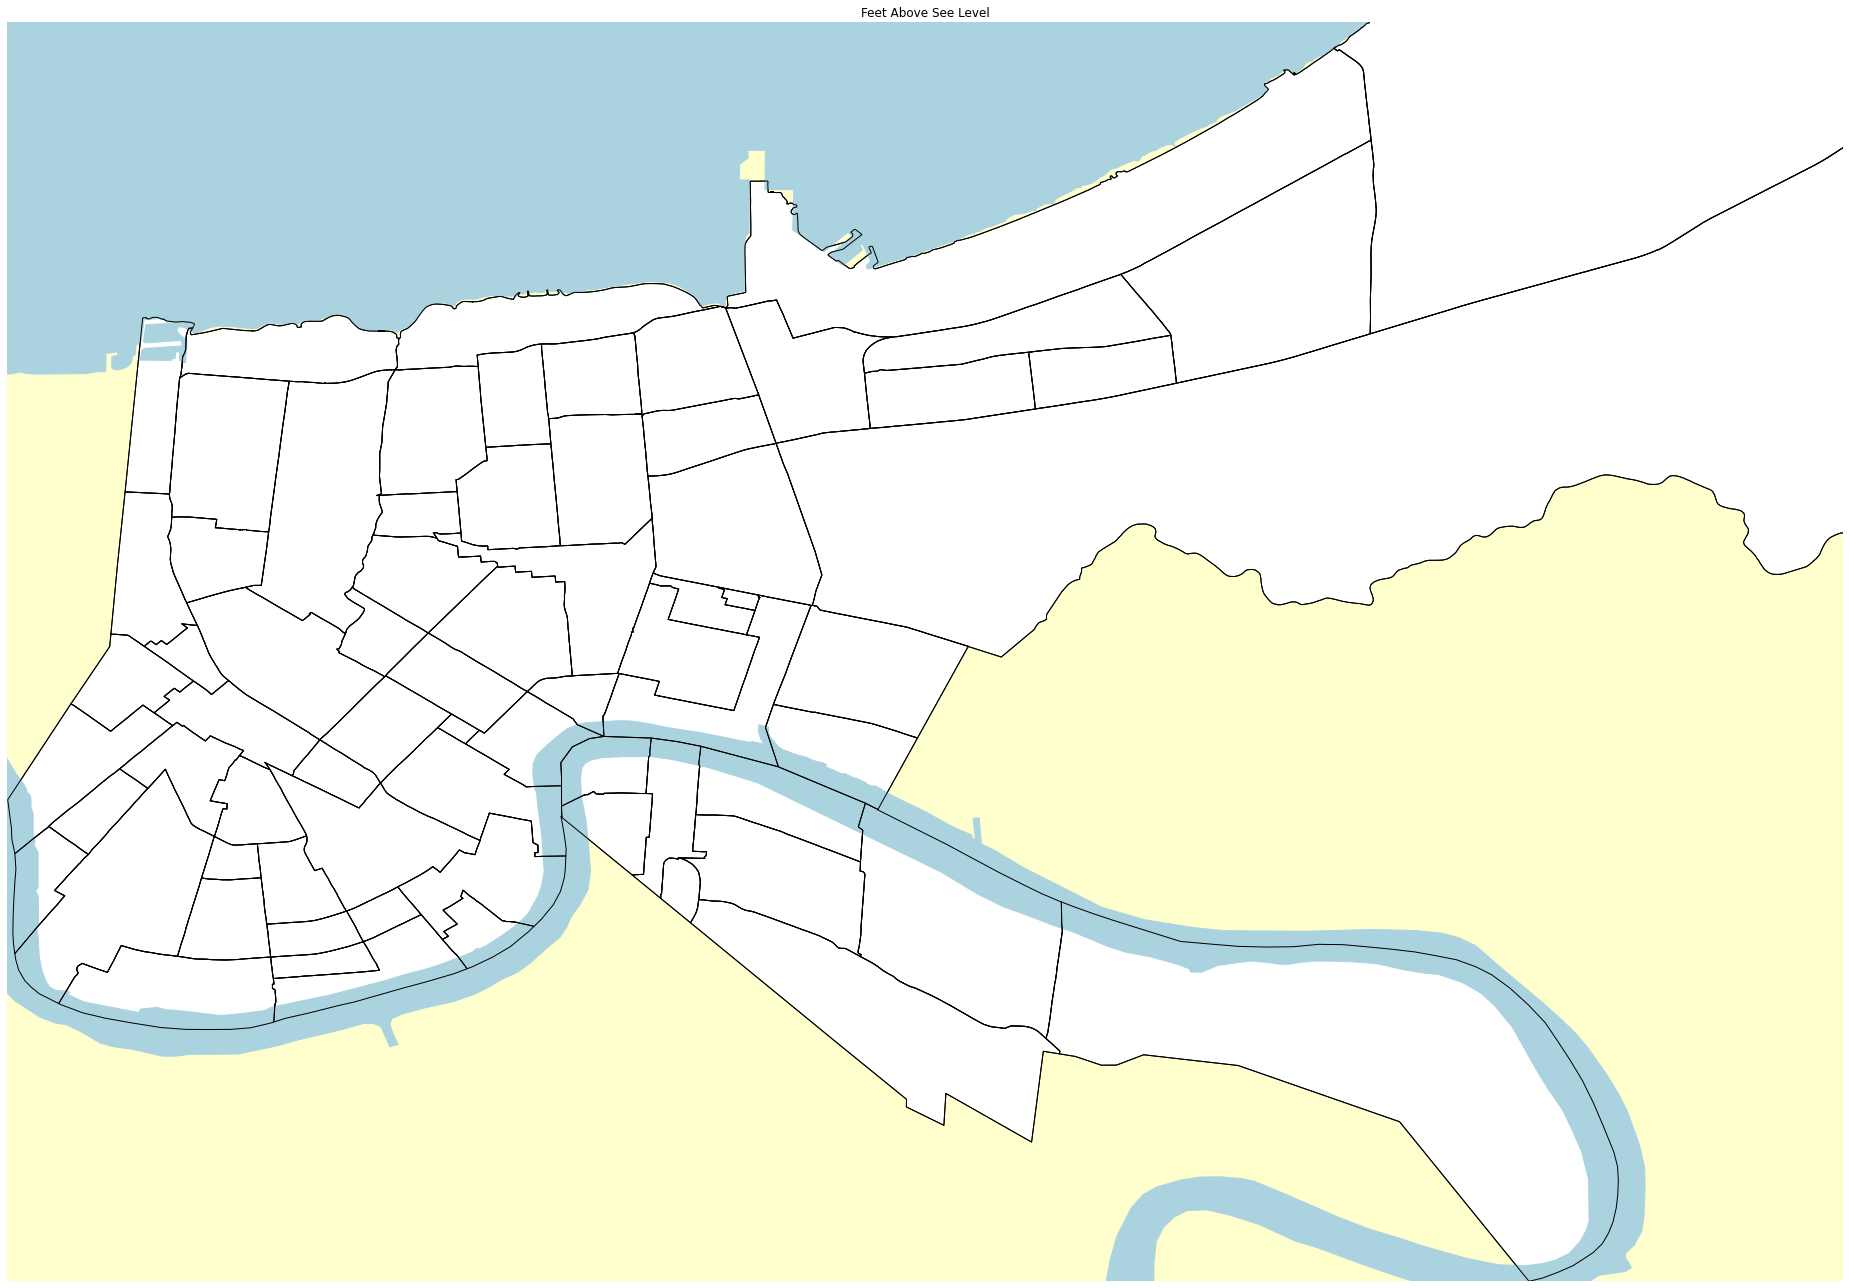

In [6]:
graphMap(saveFig=False,\
         showLidar=False,\
         annotate=False,\
         webMerc=False)